# Field and Raster Data Comparison
'''''''''' Indicates necessary cells

In [20]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [21]:
!pip install rioxarray

In [22]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import rioxarray
import pickle
import math
from shapely.geometry import Point, box
from collections import Counter

## Load Field Data and Create Buffers

In [23]:
#RUN ONCE - READING EXCEL WITH FIELD DATA
# Load Excel file with field data
df = pd.read_excel("FieldDatNTU.xlsx", sheet_name="Real Data", engine="openpyxl")

# Create point geometry from latitude and longitude
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]

# Create GeoDataFrame with WGS84
gdf_4326 = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Reproject to EPSG:3577
gdf_3577 = gdf_4326.to_crs(epsg=3577)

# Create 50 m buffer around each point
gdf_3577["geometry"] = gdf_3577.geometry.buffer(20)

# Convert column datetime to string
for col in gdf_3577.select_dtypes(include=['datetime64[ns]']).columns:
    gdf_3577[col] = gdf_3577[col].astype(str)

#Save as shapefile
gdf_3577.to_file("buffer_fielddata.shp", driver="ESRI Shapefile")

gdf_3577

,OBJECTID *,Shape *,ID,Latitude,Longitude,DATE,MEASUREMENT,DATE.1,MEASUREMENT.1,DATE.2,MEASUREMENT.2,DATE.3,MEASUREMENT.3,geometry
0,14,Point,BCF0002,-28.03620,153.3921,2025-01-30,11,2025-05-28,10,2025-07-31,9,NaT,NaN,"POLYGON ((2068168.009 -3216622.230, 2068167.91..."
1,5,Point,BEC0001,-27.76280,153.3623,2025-02-11,11,2025-04-07,51,2025-04-07,31,NaT,NaN,"POLYGON ((2070418.765 -3185896.047, 2070418.66..."
2,6,Point,BIC0008,-27.92615,153.4043,2025-01-29,5,2025-11-04,7,2025-07-08,5,NaT,NaN,"POLYGON ((2071395.248 -3204646.508, 2071395.15..."
3,7,Point,BWC0001,-27.99901,153.4156,2025-01-30,3,2025-04-09,6,2025-07-10,2,NaT,NaN,"POLYGON ((2071114.751 -3212889.126, 2071114.65..."
4,12,Point,CIW0012,-28.04297,153.4058,2025-01-30,5,2025-05-28,9,2025-07-31,4,NaT,NaN,"POLYGON ((2069353.424 -3217592.946, 2069353.32..."
5,9,Point,COC0007,-27.91767,153.3489,2025-01-28,13,2025-04-08,29,2025-05-08,6,2025-07-07,3.0,"POLYGON ((2066242.281 -3202811.336, 2066242.18..."
6,1,Point,COC0018,-27.89155,153.3803,2025-01-28,4,2025-04-08,5,2025-05-08,5,2025-07-07,3.0,"POLYGON ((2069740.994 -3200430.160, 2069740.89..."
7,17,Point,CON0001,-28.02706,153.4268,2025-01-30,5,2025-04-09,9,2025-07-10,2,NaT,NaN,"POLYGON ((2071662.421 -3216173.419, 2071662.32..."
8,11,Point,DUC0001,-28.06927,153.4202,2025-01-30,3,2025-04-09,8,2025-07-10,3,NaT,NaN,"POLYGON ((2070240.049 -3220735.393, 2070239.95..."
9,16,Point,LOC0005,-27.95540,153.4103,2025-01-29,4,2025-04-11,3,2025-07-08,4,NaT,NaN,"POLYGON ((2071423.083 -3207979.296, 2071422.98..."


## Load Raster and GeoDataFrame

In [24]:
#''''''
gdf = gpd.read_file("buffer_fielddata.gpkg")
with open("ndti.pkl", "rb") as f:
    ndti = pickle.load(f)
with open("ndvi.pkl", "rb") as f:
    ndvi = pickle.load(f)
with open("evi.pkl", "rb") as f:
    evi = pickle.load(f)

In [25]:
gdf


,OBJECTID *,Shape *,ID,Latitude,Longitude,JAN25_NTU,FEB25_NTU,MAR25_NTU,APR25_NTU,MAY25_NTU,JUN25_NTU,JUL25_NTU,geometry
0,14,Point,BCF0002,-28.03620,153.3921,10.0,11.0,11.5,11.0,10.0,9.5,8.0,"POLYGON ((2068168.009 -3216622.230, 2068167.91..."
1,5,Point,BEC0001,-27.76280,153.3623,6.0,11.0,20.0,51.0,50.0,40.0,30.0,"POLYGON ((2070418.765 -3185896.047, 2070418.66..."
2,6,Point,BIC0008,-27.92615,153.4043,5.0,4.5,5.2,6.5,6.5,5.5,5.0,"POLYGON ((2071395.248 -3204646.508, 2071395.15..."
3,7,Point,BWC0001,-27.99901,153.4156,2.5,3.0,4.0,5.5,5.0,3.5,1.5,"POLYGON ((2071114.751 -3212889.126, 2071114.65..."
4,12,Point,CIW0012,-28.04297,153.4058,4.0,5.0,6.0,7.0,8.5,9.0,4.0,"POLYGON ((2069353.424 -3217592.946, 2069353.32..."
5,9,Point,COC0007,-27.91767,153.3489,10.0,12.0,20.0,30.0,6.0,5.0,4.0,"POLYGON ((2066242.281 -3202811.336, 2066242.18..."
6,1,Point,COC0018,-27.89155,153.3803,4.0,4.0,4.5,6.0,4.5,4.0,3.0,"POLYGON ((2069740.994 -3200430.160, 2069740.89..."
7,17,Point,CON0001,-28.02706,153.4268,3.5,4.5,6.0,8.5,8.0,5.5,2.0,"POLYGON ((2071662.421 -3216173.419, 2071662.32..."
8,11,Point,DUC0001,-28.06927,153.4202,2.0,2.5,5.0,7.5,7.0,4.0,2.5,"POLYGON ((2070240.049 -3220735.393, 2070239.95..."
9,16,Point,LOC0005,-27.95540,153.4103,4.0,3.5,3.0,2.5,2.5,3.0,3.5,"POLYGON ((2071423.083 -3207979.296, 2071422.98..."


In [26]:
ndti.time

<xarray.DataArray 'time' (time: 7)> Size: 56B
array(['2025-02-08T23:54:50.314929000', '2025-03-30T23:54:46.443838000',
       '2025-04-09T23:54:42.854917000', '2025-04-19T23:54:45.205361000',
       '2025-06-08T23:54:44.309727000', '2025-06-18T23:54:42.316699000',
       '2025-07-18T23:54:47.214795000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 56B 2025-02-08T23:54:50.314929 ... 202...
    spatial_ref  int32 4B 3577
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [27]:
#Make sure both coordinate systems are the same
ndti = ndti.rio.write_crs("EPSG:3577")
print(f"Raster CRS: {ndti.rio.crs}, Point CRS: {gdf.crs}")

Raster CRS: EPSG:3577, Point CRS: EPSG:3577


## Graph Points Over Area Of Interest

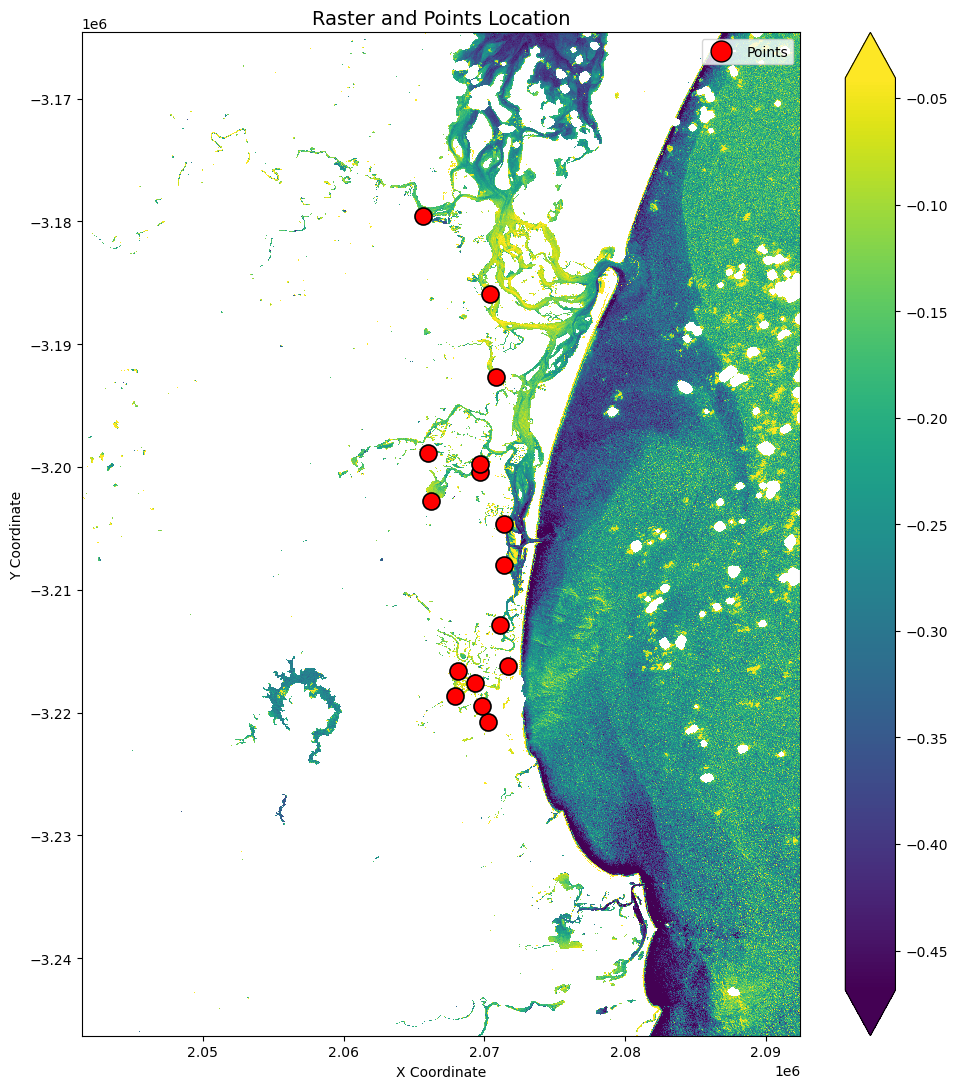

In [28]:
#Graph to check overlapping
from matplotlib.lines import Line2D

# Select one time slice
ndti_slice = ndti.isel(time=0)

# Calculate combined extent
raster_bounds = ndti_slice.rio.bounds()
points_bounds = gdf.total_bounds
combined_extent = [
    min(raster_bounds[0], points_bounds[0]),
    max(raster_bounds[2], points_bounds[2]),
    min(raster_bounds[1], points_bounds[1]),
    max(raster_bounds[3], points_bounds[3])
]

fig, ax = plt.subplots(figsize=(10, 11))

# Plot raster
ndti_slice.plot.imshow(ax=ax, cmap="viridis", robust=True, extent=combined_extent)

# Use centroids for point plotting
centroids = gdf.geometry.centroid
x_coords = centroids.x
y_coords = centroids.y

# Plot points
ax.scatter(x_coords, y_coords, s=150, color="red", edgecolor="black", linewidth=1.2, label="Points")

# Custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Points',
                          markerfacecolor='red', markeredgecolor='black', markersize=15)]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_title("Raster and Points Location", fontsize=14)
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

plt.tight_layout()
plt.show()

## Extract Zonal Mean Values from Raster NDTI and NDVI

In [29]:
from tqdm import tqdm

# Create generic labels for each raster scene (one per time step)
time_labels = [f"Scene_{i+1}" for i in range(ndti.sizes["time"])]

# Initialize dictionary to store zonal mean values
zonal_dict = {label: [] for label in time_labels}
ids = []

# Clip the entire raster once to the bounding box of all geometries
bbox = gdf.total_bounds  # [minx, miny, maxx, maxy]
ndti_clipped = ndti.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])

# Iterate over each geometry with a progress bar
for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Calculating zonal means"):
    # Clip raster by individual geometry
    clipped = ndti_clipped.rio.clip([row.geometry], gdf.crs, drop=True)
    
    # Calculate mean for each time step (lazy evaluation)
    means = clipped.mean(dim=["x", "y"], skipna=True)
    
    # Compute and convert to list (only once per geometry)
    means_list = means.compute().values.tolist()
    
    # Store results in dictionary
    for label, val in zip(time_labels, means_list):
        zonal_dict[label].append(val)
    
    # Store geometry ID
    ids.append(row["ID"])

# Create DataFrame and save as CSV
zonal_df = pd.DataFrame(zonal_dict)
zonal_df.insert(0, "ID", ids)
zonal_df.to_csv("zonal_ndti_values.csv", index=False)

Calculating zonal means: 100%|██████████| 16/16 [12:03<00:00, 45.24s/it]


In [30]:
#Mean value NDVI for trend
mean_values = ndvi.mean(dim=["x", "y"], skipna=True).compute().values.tolist()

scene_labels = [f"Scene_{i+1}" for i in range(ndvi.sizes["time"])]

df = pd.DataFrame({
    "Scene": scene_labels,
    "Mean_NDVI": mean_values
})


df.to_csv("mean_ndvi_per_timestep.csv", index=False)


     Scene  Mean_NDVI
0  Scene_1   0.648795
1  Scene_2   0.718816
2  Scene_3   0.686704
3  Scene_4   0.667918
4  Scene_5   0.724285
5  Scene_6   0.668492
6  Scene_7   0.723207


In [31]:
#Mean value EVI for trend
mean_values = evi.mean(dim=["x", "y"], skipna=True).compute().values.tolist()

scene_labels = [f"Scene_{i+1}" for i in range(evi.sizes["time"])]

df = pd.DataFrame({
    "Scene": scene_labels,
    "Mean_EVI": mean_values
})


df.to_csv("mean_evi_per_timestep.csv", index=False)

     Scene  Mean_EVI
0  Scene_1  0.310831
1  Scene_2  0.324227
2  Scene_3  0.325151
3  Scene_4  0.337586
4  Scene_5  0.362956
5  Scene_6  0.346575
6  Scene_7  0.374147


In [32]:
#Mean value NDTI for trend
mean_values = ndti.mean(dim=["x", "y"], skipna=True).compute().values.tolist()

scene_labels = [f"Scene_{i+1}" for i in range(ndti.sizes["time"])]

df = pd.DataFrame({
    "Scene": scene_labels,
    "Mean_NDTI": mean_values
})


df.to_csv("mean_ndti_per_timestep.csv", index=False)

     Scene  Mean_NDTI
0  Scene_1  -0.244939
1  Scene_2  -0.474695
2  Scene_3  -0.214555
3  Scene_4  -0.322464
4  Scene_5  -0.394949
5  Scene_6  -0.217663
6  Scene_7  -0.310807
